# Downloading MODIS Data for Tunisia

This notebook demonstrates how to download MODIS satellite data for Tunisia, adapted from the [crop_yield_prediction](https://github.com/JiaxuanYou/crop_yield_prediction) repository.

**Author:** arfaouiahmed1  
**Date:** 2025-02-25

## Setup and Dependencies

First, let's install all necessary dependencies for downloading and processing MODIS data.

In [ ]:
!pip install pymodis
!pip install gdal
!pip install netCDF4
!pip install earthengine-api
!pip install geopandas
!pip install matplotlib
!pip install rasterio
!pip install folium

## Google Earth Engine Authentication

We'll use Google Earth Engine for easy access to MODIS data.

In [ ]:
import ee

# Authenticate to Earth Engine and provide your project ID
# Replace 'your-project-id' with your actual Google Cloud Project ID
try:
    ee.Initialize(project='farmwise-452013')  # Provide project ID here
    print("Earth Engine already initialized")
except Exception as e:
    ee.Authenticate()
    ee.Initialize(project='farmwise-452013')  # Provide project ID here
    print("Earth Engine initialized")

Earth Engine initialized


## Define Tunisia's Geographic Area

We'll define Tunisia's boundaries to focus our data retrieval.

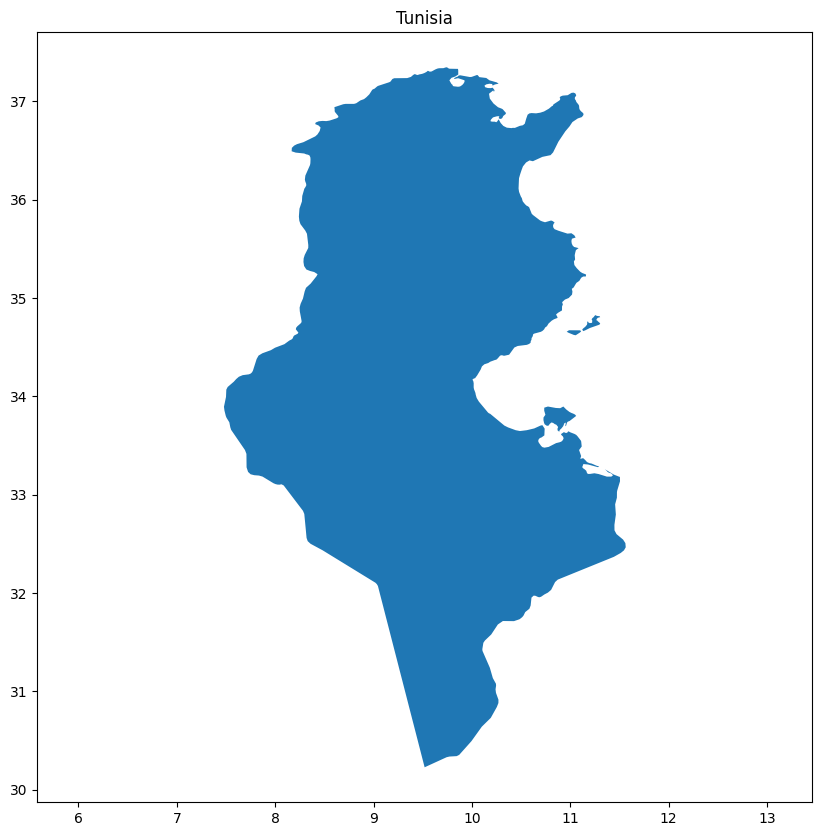

Tunisia Bounding Box: 7.479832398000099, 30.22890533500005, 11.564130900000123, 37.34520091400016


In [ ]:
import geopandas as gpd
import io
import requests
import matplotlib.pyplot as plt

# Download Tunisia's boundary from Natural Earth
url = "https://raw.githubusercontent.com/datasets/geo-countries/master/data/countries.geojson"
r = requests.get(url)
countries = gpd.read_file(io.BytesIO(r.content))

# Extract Tunisia
tunisia = countries[countries['ADMIN'] == 'Tunisia']

# Plot Tunisia's boundary
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
tunisia.plot(ax=ax)
ax.set_title('Tunisia')
plt.axis('equal')
plt.show()

# Get the bounding box of Tunisia
minx, miny, maxx, maxy = tunisia.total_bounds
print(f"Tunisia Bounding Box: {minx}, {miny}, {maxx}, {maxy}")

# Create an Earth Engine geometry for Tunisia
tunisia_ee = ee.FeatureCollection("USDOS/LSIB_SIMPLE/2017").filter(ee.Filter.eq('country_na', 'Tunisia'))

## Download MODIS Data

Here we'll download specific MODIS products for Tunisia. Let's use vegetation indices which are useful for crop yield prediction.

In [ ]:
# Define the MODIS products we want to download
# MOD13Q1: 16-day 250m Vegetation Indices (NDVI and EVI)
modis_vi = ee.ImageCollection("MODIS/061/MOD13Q1")

# MOD11A2: 8-day 1km Land Surface Temperature
modis_lst = ee.ImageCollection("MODIS/061/MOD11A2")

# Define the time range (let's get data for the year 2024)
start_date = '2024-01-01'
end_date = '2024-12-31'

# Filter the collections by date and area
vi_collection = modis_vi.filterDate(start_date, end_date).filterBounds(tunisia_ee)
lst_collection = modis_lst.filterDate(start_date, end_date).filterBounds(tunisia_ee)

# Print the number of images in each collection
print(f"Number of vegetation index images: {vi_collection.size().getInfo()}")
print(f"Number of land surface temperature images: {lst_collection.size().getInfo()}")

Number of vegetation index images: 23
Number of land surface temperature images: 46


## Visualize MODIS Data

Let's visualize the NDVI (Normalized Difference Vegetation Index) data for Tunisia.

In [ ]:
import folium

# Calculate the mean NDVI over the time period
ndvi_mean = vi_collection.select('NDVI').mean().divide(10000)  # NDVI values are scaled by 10000 in MODIS data

# Clip to Tunisia
ndvi_tunisia = ndvi_mean.clip(tunisia_ee)

# Visualization parameters
ndvi_vis = {
    'min': 0.0,
    'max': 0.8,
    'palette': [
        'FFFFFF', 'CE7E45', 'DF923D', 'F1B555', 'FCD163', '99B718',
        '74A901', '66A000', '529400', '3E8601', '207401', '056201',
        '004C00', '023B01', '012E01', '011D01', '011301'
    ]
}

# Create a map centered on Tunisia
map_center = [(miny + maxy) / 2, (minx + maxx) / 2]
mymap = folium.Map(location=map_center, zoom_start=7)

# Add the NDVI layer to the map
map_id_dict = ee.Image(ndvi_tunisia).getMapId(ndvi_vis)
folium.TileLayer(
    tiles=map_id_dict['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    name='NDVI',
    overlay=True,
    control=True
).add_to(mymap)

# Add a layer control panel to the map
folium.LayerControl().add_to(mymap)

# Display the map
mymap

NameError: name 'vi_collection' is not defined

## Download Data for Further Analysis

Now let's download the data for offline analysis.

In [ ]:
# Function to download an Earth Engine image
def download_ee_image(image, region, filename, scale=500):  # Increased scale to reduce file size
    try:
        # Method 1: Try direct download with higher scale (reduced resolution)
        url = image.getDownloadURL({
            'region': region,
            'scale': scale,
            'format': 'GEO_TIFF',
            'maxPixels': 1e9
        })
        response = requests.get(url)
        with open(filename, 'wb') as f:
            f.write(response.content)
        print(f"Downloaded {filename}")
    except Exception as e:
        print(f"Direct download failed: {e}")
        print("Trying alternative export to Google Drive...")

        # Method 2: Export to Google Drive if direct download fails
        task = ee.batch.Export.image.toDrive(
            image=image,
            description=f'Export_{filename.replace("/", "_").replace(".", "_")}',
            folder='tunisia_modis_data',
            fileNamePrefix=os.path.basename(filename).replace('.tif', ''),
            region=region,
            scale=scale,
            maxPixels=1e9
        )
        task.start()
        print(f"Started export task for {filename}. Check your Google Drive folder 'tunisia_modis_data' when complete.")

# Create directory if it doesn't exist
!mkdir -p tunisia_modis_data

# Convert Tunisia EE feature to geometry for download
tunisia_geometry = tunisia_ee.geometry()

# Method 3: Reduce the area - Focus on agricultural regions only
# Define the main agricultural areas in northern Tunisia
northern_tunisia = ee.Geometry.Rectangle([7.5, 35.5, 11.5, 37.5])
agricultural_tunisia = northern_tunisia.intersection(tunisia_geometry)

# Download average NDVI with reduced area and higher scale
print("Downloading average NDVI for agricultural regions...")
download_ee_image(ndvi_tunisia, agricultural_tunisia, 'tunisia_modis_data/tunisia_agricultural_ndvi_mean_2024.tif', scale=500)

# Method 4: Split into smaller regions
# Divide Tunisia into 4 quadrants
bounds = tunisia_geometry.bounds().getInfo()['coordinates'][0]
min_x = min(p[0] for p in bounds)
max_x = max(p[0] for p in bounds)
min_y = min(p[1] for p in bounds)
max_y = max(p[1] for p in bounds)
mid_x = (min_x + max_x) / 2
mid_y = (min_y + max_y) / 2

quadrants = [
    ee.Geometry.Rectangle([min_x, min_y, mid_x, mid_y]),  # SW
    ee.Geometry.Rectangle([mid_x, min_y, max_x, mid_y]),  # SE
    ee.Geometry.Rectangle([min_x, mid_y, mid_x, max_y]),  # NW
    ee.Geometry.Rectangle([mid_x, mid_y, max_x, max_y])   # NE
]

# Download first NDVI image as separate quadrants
first_vi_image = ee.Image(vi_collection.first())
ndvi_first = first_vi_image.select('NDVI').divide(10000).clip(tunisia_ee)

for i, quad in enumerate(quadrants):
    intersection = quad.intersection(tunisia_geometry)
    print(f"Downloading NDVI quadrant {i+1}...")
    download_ee_image(ndvi_first, intersection, f'tunisia_modis_data/tunisia_ndvi_first_2024_quadrant_{i+1}..', scale=500)

print("All download tasks initiated. Some files may be available in your Google Drive if direct download failed.")

Downloaded tunisia_modis_data/tunisia_agricultural_ndvi_mean_2024.tif
Downloaded tunisia_modis_data/tunisia_ndvi_first_2024_quadrant_1..
Downloaded tunisia_modis_data/tunisia_ndvi_first_2024_quadrant_2..
Downloaded tunisia_modis_data/tunisia_ndvi_first_2024_quadrant_3..
Downloaded tunisia_modis_data/tunisia_ndvi_first_2024_quadrant_4..
All download tasks initiated. Some files may be available in your Google Drive if direct download failed.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Analysis of NDVI Time Series

Let's analyze how the vegetation changes over time.

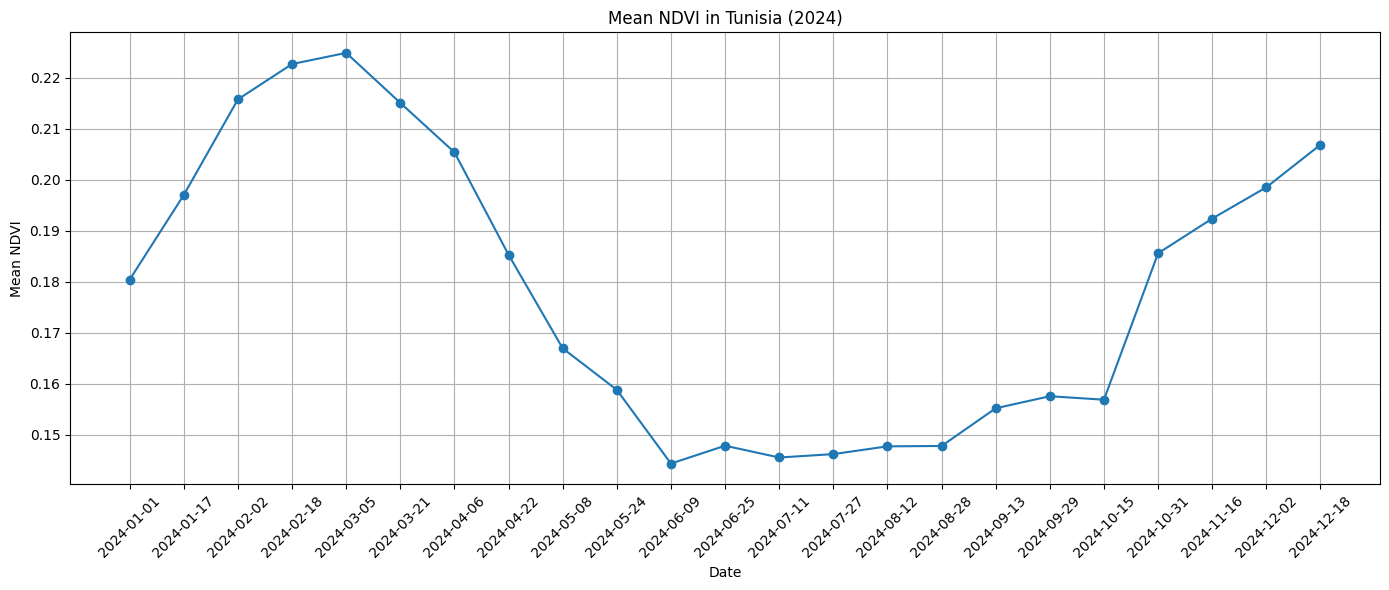

In [ ]:
# Get all NDVI images in the collection
ndvi_images = vi_collection.select('NDVI')

# Get list of dates
def extract_date(image):
    date = ee.Date(image.get('system:time_start'))
    return ee.Feature(None, {'date': date.format('YYYY-MM-dd')})

dates = ndvi_images.map(extract_date).aggregate_array('date').getInfo()

# Calculate mean NDVI for Tunisia for each date
def get_mean_ndvi(image):
    mean = image.divide(10000).clip(tunisia_ee).reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=tunisia_ee,
        scale=250,
        maxPixels=1e9
    ).get('NDVI')
    return ee.Feature(None, {'ndvi': mean, 'date': ee.Date(image.get('system:time_start')).format('YYYY-MM-dd')})

ndvi_stats = ndvi_images.map(get_mean_ndvi)
ndvi_values = ndvi_stats.aggregate_array('ndvi').getInfo()
ndvi_dates = ndvi_stats.aggregate_array('date').getInfo()

# Plot NDVI time series
plt.figure(figsize=(14, 6))
plt.plot(ndvi_dates, ndvi_values, marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Mean NDVI')
plt.title('Mean NDVI in Tunisia (2024)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()

## Exploring Agricultural Regions

Let's identify and analyze key agricultural regions in Tunisia.

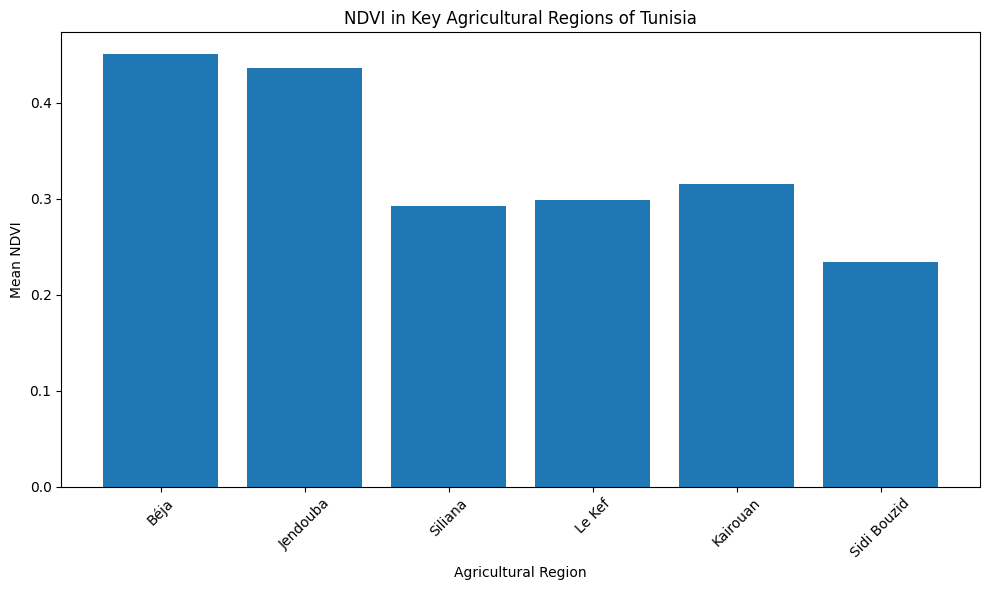

In [ ]:
# Define important agricultural governorates in Tunisia
# These are approximate points for major agricultural regions
agricultural_regions = {
    'Béja': [36.7333, 9.1833],
    'Jendouba': [36.5011, 8.7803],
    'Siliana': [36.0850, 9.3700],
    'Le Kef': [36.1667, 8.7000],
    'Kairouan': [35.6780, 10.0963],
    'Sidi Bouzid': [35.0381, 9.4858],
}

# Create buffer zones around these regions (10km buffer)
region_geometries = {}
for name, coords in agricultural_regions.items():
    point = ee.Geometry.Point([coords[1], coords[0]])  # [lon, lat]
    buffer = point.buffer(10000)  # 10km buffer
    region_geometries[name] = buffer

# Analyze the NDVI for each region for the first date
first_ndvi = ee.Image(ndvi_images.first()).divide(10000)

region_ndvi = {}
for name, geom in region_geometries.items():
    mean_ndvi = first_ndvi.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=geom,
        scale=250,
        maxPixels=1e9
    ).get('NDVI').getInfo()
    region_ndvi[name] = mean_ndvi

# Plot the NDVI values for each agricultural region
plt.figure(figsize=(10, 6))
plt.bar(region_ndvi.keys(), region_ndvi.values())
plt.xlabel('Agricultural Region')
plt.ylabel('Mean NDVI')
plt.title('NDVI in Key Agricultural Regions of Tunisia')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Export MODIS Time Series Data

Let's export the NDVI time series for each agricultural region.

,ndvi_Béja,ndvi_Jendouba,ndvi_Siliana,ndvi_Le Kef,ndvi_Kairouan,ndvi_Sidi Bouzid
date,,,,,,
2024-01-01,0.450754,0.436404,0.292592,0.299037,0.315405,0.234060
2024-01-17,0.597950,0.595744,0.377531,0.373775,0.387811,0.247348
2024-02-02,0.707742,0.701266,0.465819,0.447926,0.446987,0.273673
2024-02-18,0.753040,0.751232,0.532057,0.539060,0.463071,0.271706
2024-03-05,0.771933,0.745762,0.531288,0.568489,0.436506,0.274019


Time series data saved to CSV


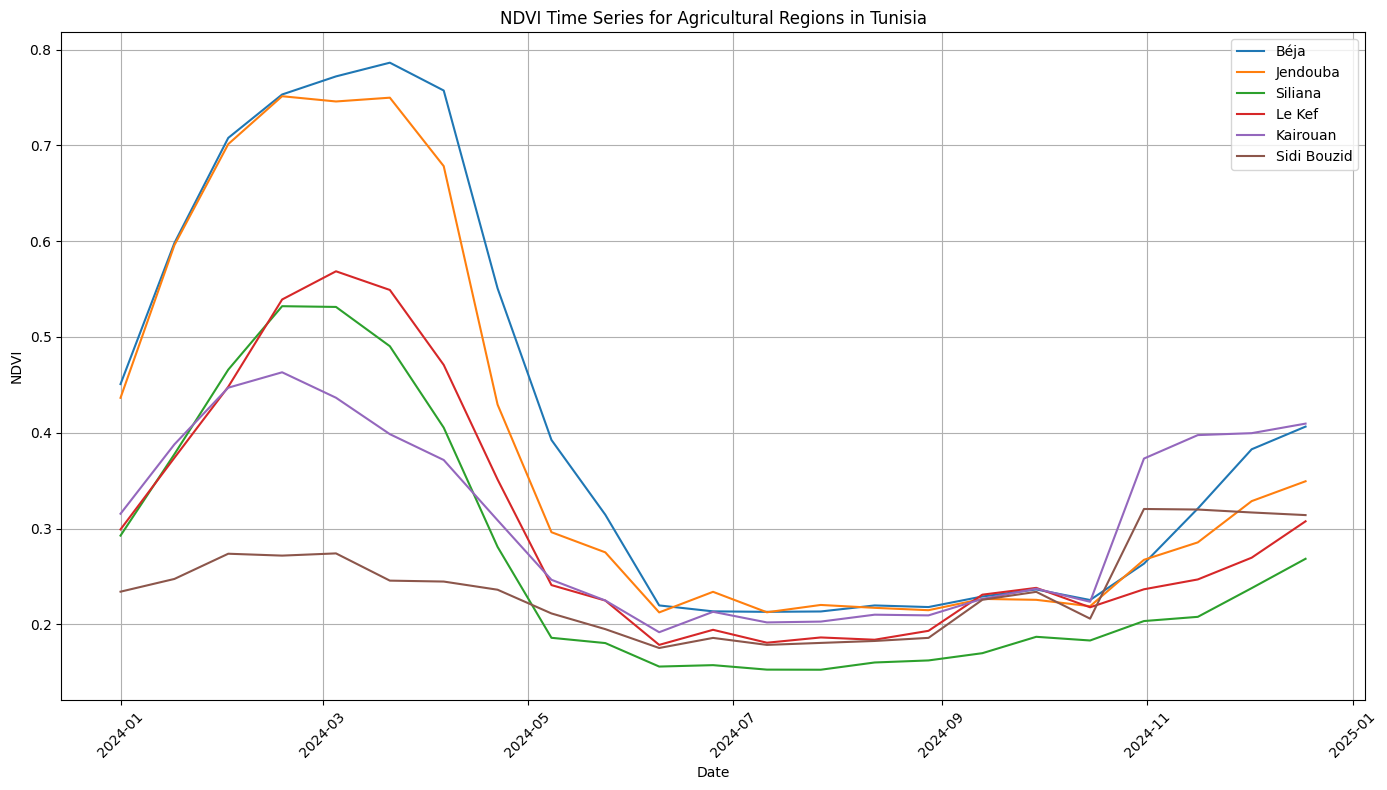

In [ ]:
import pandas as pd
from datetime import datetime

# Create a function to extract NDVI time series for a region
def get_region_ndvi_series(region_name, region_geometry):
    def extract_ndvi(image):
        date = ee.Date(image.get('system:time_start'))
        mean_ndvi = image.divide(10000).reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=region_geometry,
            scale=250,
            maxPixels=1e9
        ).get('NDVI')
        return ee.Feature(None, {'date': date.format('YYYY-MM-dd'), 'ndvi': mean_ndvi})

    features = ndvi_images.map(extract_ndvi)
    dates = features.aggregate_array('date').getInfo()
    ndvi_vals = features.aggregate_array('ndvi').getInfo()

    return pd.DataFrame({'date': dates, f'ndvi_{region_name}': ndvi_vals})

# Get NDVI time series for each region
region_dfs = []
for name, geom in region_geometries.items():
    df = get_region_ndvi_series(name, geom)
    if len(region_dfs) == 0:
        region_dfs.append(df)
    else:
        region_dfs.append(df.drop('date', axis=1))

# Combine all region data
all_regions_df = pd.concat(region_dfs, axis=1)
all_regions_df['date'] = pd.to_datetime(all_regions_df['date'])
all_regions_df.set_index('date', inplace=True)

# Display the resulting DataFrame
display(all_regions_df.head())

# Save the data to CSV
all_regions_df.to_csv('tunisia_modis_data/agricultural_regions_ndvi_timeseries.csv')
print('Time series data saved to CSV')

# Plot the time series for all regions
plt.figure(figsize=(14, 8))
for column in all_regions_df.columns:
    plt.plot(all_regions_df.index, all_regions_df[column], label=column.replace('ndvi_', ''))
plt.xlabel('Date')
plt.ylabel('NDVI')
plt.title('NDVI Time Series for Agricultural Regions in Tunisia')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Conclusion and Next Steps

In this notebook, we've successfully:

1. Downloaded MODIS vegetation indices data for Tunisia
2. Visualized the spatial distribution of NDVI
3. Analyzed time series trends of vegetation across the country
4. Compared NDVI values across major agricultural regions
5. Exported the data for further analysis

For crop yield prediction, you can:

1. Collect ground truth data about crop yields in Tunisia
2. Combine the MODIS data with other variables like precipitation, temperature, soil moisture
3. Build machine learning models following the approach in the original repository
4. Validate and refine the models for Tunisia's specific agricultural conditions